# DESI DR1 Stream Tutorial - Work In Progess!!

Welcome to the 2025 version of our stellar stream characterization tutorial notebook. This notebook will walk you through using data from the DESI Milky Way Survey data from the first full public release!

Below, we're going to import the packages we'll be using.

```python
#-----------------------#

#Look here for stuff to change throughout the notebook!

#-----------------------#
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats
from astropy.io import fits
from astropy import table
import matplotlib
import matplotlib.patheffects as path_effects
import importlib
import stream_functions as stream_funcs
importlib.reload(stream_funcs)
import galstreams
import emcee
import corner
from astropy import units as u
from collections import OrderedDict
import time
from scipy import optimize, stats
import matplotlib.colors as mcolors
colors = mcolors.CSS4_COLORS
color_names = list(colors.keys())
import streamTutorial as st
import copy
importlib.reload(st);


Next, let's input our DESI MWS DR1 data. 

In [2]:
importlib.reload(st)
# Add the path to the DESI data and STREAMFINDER data below
#-----------------------#
desi_path = '/raid/DESI_public/data/mwsall-pix-iron.fits'
sf_path = '/raid/catalogs/streamfinder_gaiadr3.fits'
#-----------------------#

Data = st.Data(desi_path, sf_path)

print('Now our desi data has been loaded under Data.desi_data')


Length of DESI Data before Cuts: 6372607
Length after NaN cut: 4075716
Adding empirical FEH calibration (can find uncalibrated data in column['FEH_uncalib])
Now our desi data has been loaded under Data.desi_data


# Pick Stream

We'll pick a stream to work with by entering it in 
```python 
st.stream(Data, streamName='SoI-I21', streamNo=42)
```

Initializing this stream object will add an attribute to the `Data` object, accessed either through

`Data.confirmed_sf_and_desi` or `SoI.data.confirmed_sf_and_desi`

It will also calculate the *stream coordinates* $\phi_1$ and $\phi_2$. This is achieved by rotating the right ascension and declination such that the length of the stream lies along $\phi_2 \sim 0$, and the center of the stream is $\phi_1 \sim 0$.

In [3]:
#del SoI

In [4]:
importlib.reload(stream_funcs)

#-----------------------#
streamName= 'Fjorm-I21' #'Sylgr-I21'
streamNo= 47 #42
#-----------------------#

importlib.reload(st)
SoI = st.stream(Data, streamName, streamNo)

Importing galstreams module...
Initializing galstreams library from master_log... 


0.0001777348446481142
Creating combined DataFrame of SF and DESI
No original data available for comparison - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 297, Number of DESI and SF stars: 30
Saved merged DataFrame as self.data.confirmed_sf_and_desi
Stars only in SF3: 265


Lets take a look at the rotated stream below

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:649: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



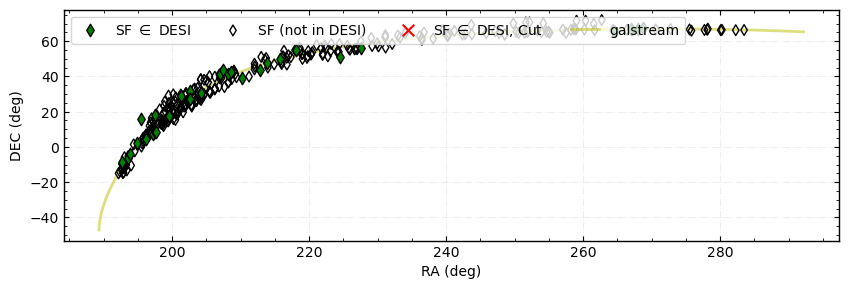

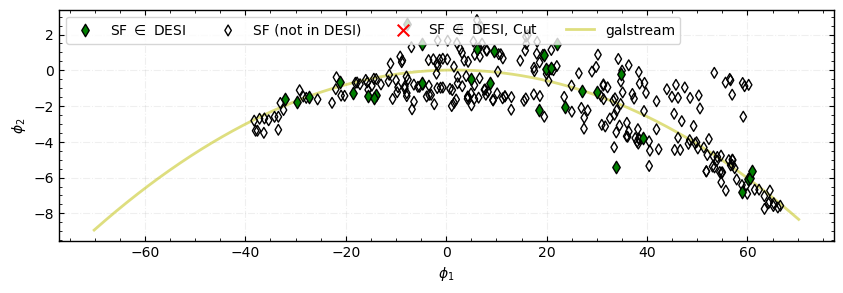

In [5]:
importlib.reload(st)
plt_soi = st.StreamPlotter(SoI)

plt_soi.on_sky(stream_frame=False)
plt_soi.on_sky(stream_frame=True)

# Trimming DESI Data
We have lots of DESI data, lets cut that down with the following steps:
- Perform a distance cut to remove stars too nearby
- Perform an RA/DEC cut to remove stars on different parts of the sky
- Trim stars with kinematics nothing like the STREAMFINDER stars
- Trim stars that are too metal rich
- Trim stars that fall outside of the best-fit stellar population model

The first two bullet points can be achieved using a handy function we have stored in `stream_functions.py`

`stream_funcs.threeD_max_min_mask`

In [6]:
importlib.reload(st)
selection_fine = st.Selection(SoI.data.desi_data)

# We want to get the ra and dec from STREAMFINDER stars for this function so we can cut around it


#-----------------------#
ra_cut = 5 #deg
dec_cut = 5 #deg
#-----------------------#

selection_fine.add_mask(name='3D',
        mask_func=lambda df: stream_funcs.threeD_max_min_mask(
        df['TARGET_RA'],        
        df['TARGET_DEC'],         
        df['PARALLAX'],       
        df['PARALLAX_ERROR'],   
        SoI.data.SoI_streamfinder['RAdeg'],         
        SoI.data.SoI_streamfinder['DEdeg'],        
        SoI.min_dist,              
        ra_cut,dec_cut) #<-----------------------# dec cut, ra cut (wide cuts for now)
)

Selection object created for DataFrame with 4075716 rows.
Mask added: '3D'


Once we've done all our cuts, we can get all our masks in one using `final_mask = st.Selection.get_final_mask()`

Combining masks...
...'3D' selected 1887283 stars
Selection: 1887283 / 4075716 stars.
No stars were cut - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 297, Number of DESI and SF stars: 30
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 265
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:649: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



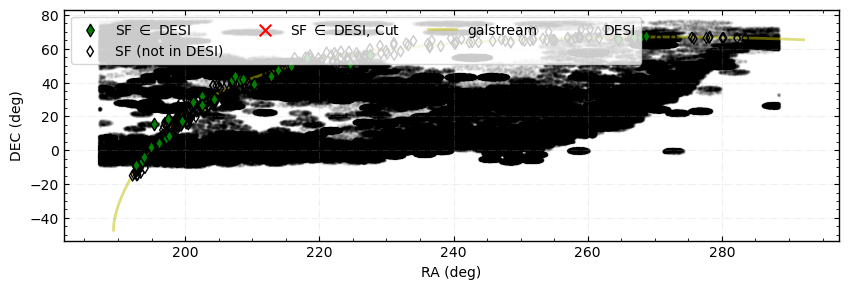

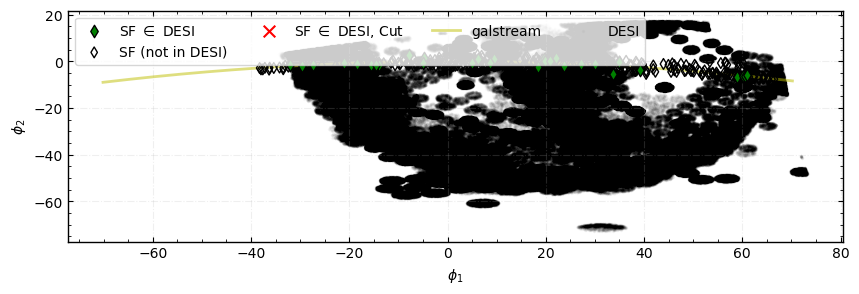

In [7]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data

final_mask = selection_fine.get_final_mask()

# Using the new method that replaces the 4-line pattern
trimmed_stream = SoI.mask_stream(final_mask)

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.on_sky(showStream=True, background=True, stream_frame=False)
plt_trim.on_sky(showStream=True, background=True)

Lets also look at our parallax cut:

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:715: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



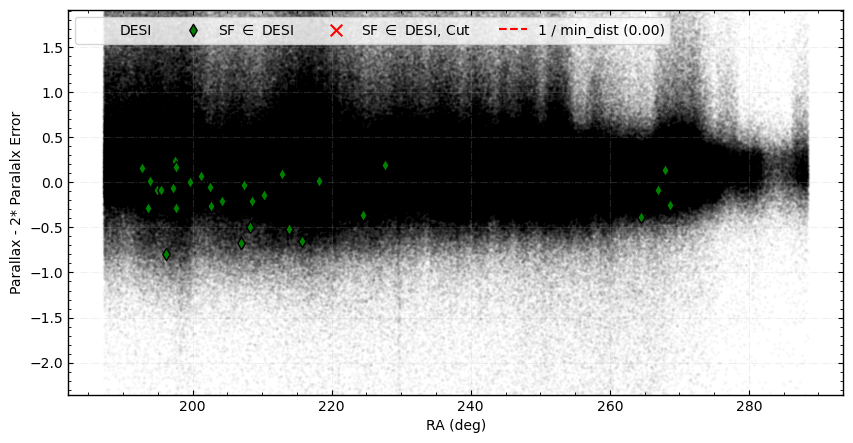

In [8]:
plt_trim.plx_cut()

#del plt_trim, trimmed_desi, trimmed_stream # clear memory

Now that we've visualized the stream in the stream-frame, we can get a bit more specific with our on-sky cuts.

In [9]:
#-----------------------#
phi2_wiggle = 5 #[deg]
#-----------------------#

selection_fine.add_mask(name='phi2',
        mask_func=lambda df: (df['phi2'] < phi2_wiggle) & (df['phi2'] > -1*phi2_wiggle))

Mask added: 'phi2'


In [10]:
# del plt_trim

...'3D' selected 1887283 stars
...'phi2' selected 275775 stars
Selection for specified masks: 235258 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 5 stars that were filtered out
Number of stars in SF: 297, Number of DESI and SF stars: 25
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b


Stars only in SF3: 270
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:649: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



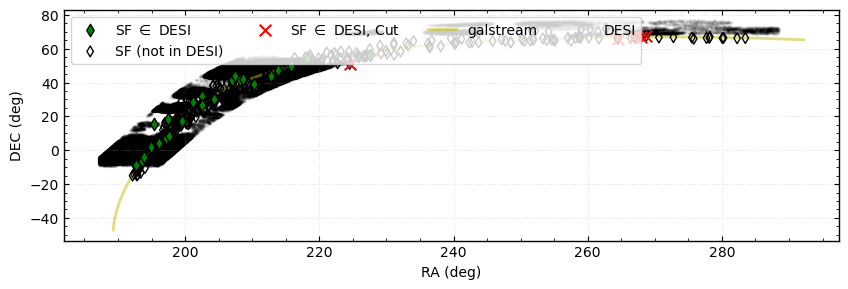

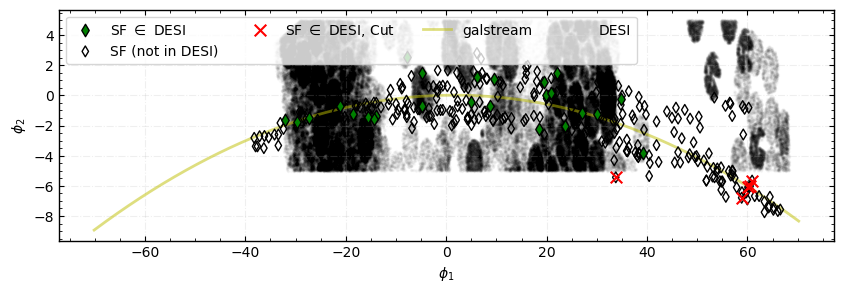

In [11]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data
mask = selection_fine.get_masks(['3D', 'phi2'])

trimmed_stream = SoI.mask_stream(mask)

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.on_sky(showStream=True, background=True, stream_frame=False)
plt_trim.on_sky(showStream=True, background=True)

# Metallicity and Isochrone Cuts

## Metallicity
Lets grab the stream's known metallicity from STREAMFINDER

In [12]:
sf3_table = pd.read_csv('./data/sf3_only_table.csv')


sf_streamname = streamName.rsplit('-', 1)[0] #If this fails, manually enter the stream name from the first table.
metallicity = sf3_table[sf3_table['Stream'] == sf_streamname]['Metallicities'].values
print(f"{sf_streamname} Metallicity: {metallicity}")
print(f'Mass Fraction (Z) Guess: {0.0181 * 10 ** metallicity}')


Fjorm Metallicity: [-2.23]
Mass Fraction (Z) Guess: [0.00010658]


/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:893: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



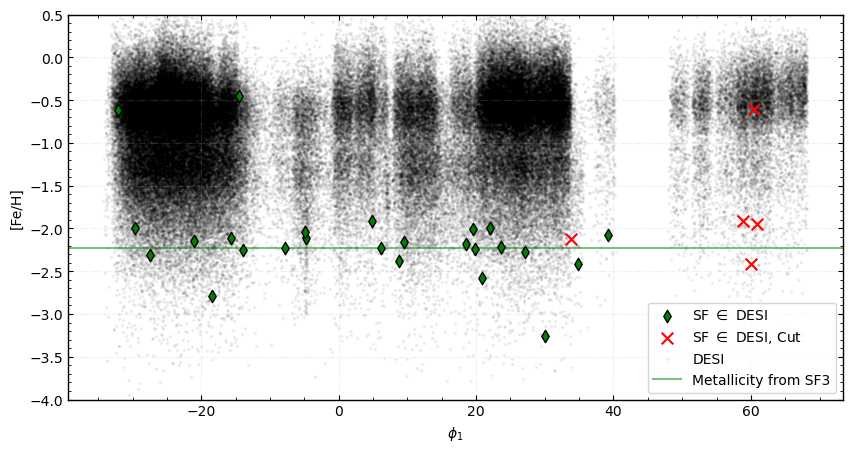

In [13]:
plt_trim.plot_params['background']['alpha']=0.05
plot = plt_trim.feh_plot(showStream=True, background=True)
ax = plot[1]
ax.axhline(metallicity, color='g', linestyle='solid', label='Metallicity from SF3', alpha=0.5)
ax.legend()

Now lets trim stars that are too metal rich!

In [ ]:
#-----------------------#
feh_cut = -1.5 # [dex]
#-----------------------#

selection_fine.add_mask(name='feh',
        mask_func=lambda df: (df['FEH'] < feh_cut))

Mask added: 'feh'


...'3D' selected 1887283 stars
...'phi2' selected 275775 stars
...'feh' selected 770814 stars
Selection for specified masks: 59693 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 7 stars that were filtered out
Number of stars in SF: 297, Number of DESI and SF stars: 23
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 274
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:893: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



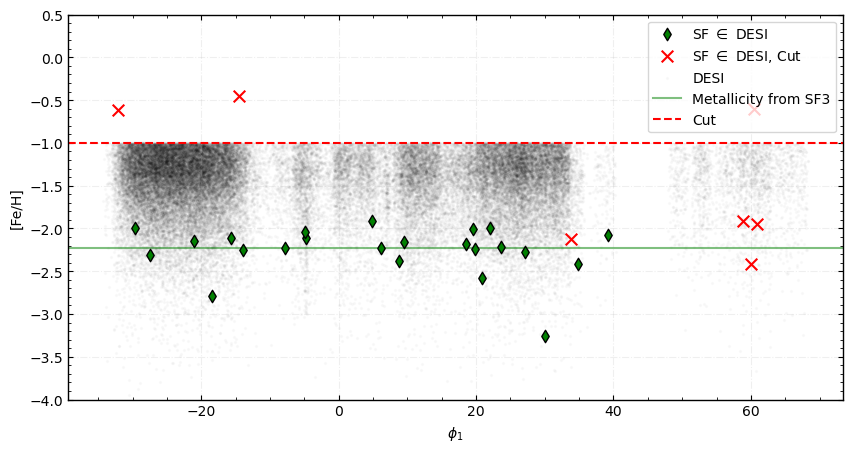

In [15]:
#del trimmed_stream, plt_trim # clear memory
importlib.reload(st)
mask = selection_fine.get_masks(['3D', 'phi2', 'feh'])

trimmed_stream = SoI.mask_stream(mask)


plt_trim = st.StreamPlotter(trimmed_stream)
plot = plt_trim.feh_plot(showStream=True, background=True)
ax = plot[1]
ax.axhline(metallicity, color='g', linestyle='solid', label='Metallicity from SF3', alpha=0.5)
ax.axhline(feh_cut, color='red', linestyle='--', label='Cut')
ax.legend(loc='upper right')

## Isochrone

Lets try to fit an isochrone to the STREAMFINDER stars and trimming in one fell swoop.

In [16]:
#-----------------------#
colour_wiggle = 0.15 # [dex]
age = 13.5 # [Gyr] -> of form 10.0, 10.1, 10.2, etc
#-----------------------#
SoI.isochrone(metallicity, age=age) 

selection_fine.add_mask(name='iso',
        mask_func=lambda df: (stream_funcs.betw(SoI.data.desi_colour_idx, SoI.isochrone_fit(SoI.data.desi_abs_mag), colour_wiggle)))

using ./data/dotter/iso_a13.5_z0.00006.dat
Using distance gradient
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/stream_functions.py:635: RuntimeWarning: invalid value encountered in log10
  R_mag = r_mag - 5 * np.log10(distances) + 5

Mask added: 'iso'


...'3D' selected 1887283 stars
...'phi2' selected 275775 stars
...'feh' selected 770814 stars
...'iso' selected 895726 stars
Selection for specified masks: 26661 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 13 stars that were filtered out
Number of stars in SF: 297, Number of DESI and SF stars: 17
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 280
using ./data/dotter/iso_a13.5_z0.00006.dat
Using distance gradient
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:947: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



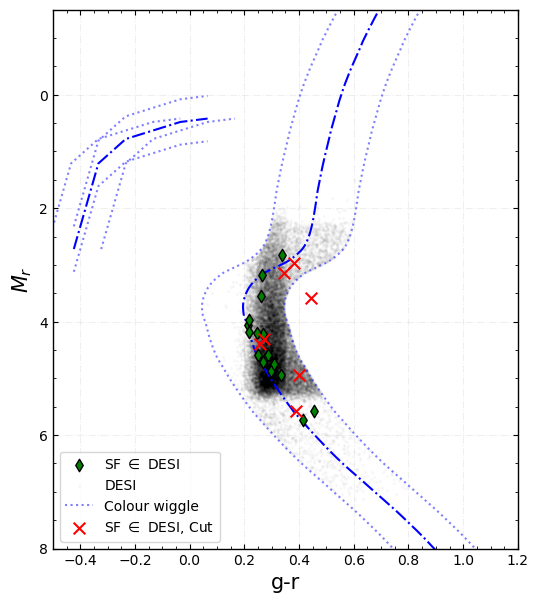

In [17]:
importlib.reload(st)
mask = selection_fine.get_masks(['3D', 'phi2', 'feh', 'iso'])

trimmed_stream = SoI.mask_stream(mask)
trimmed_stream.isochrone(metallicity, age=age) 

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.iso_plot(wiggle=colour_wiggle, background=True, showStream=True)

# Kinematic Cuts

DESI's radial velocity

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:772: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:777: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:782: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[2].scatter(



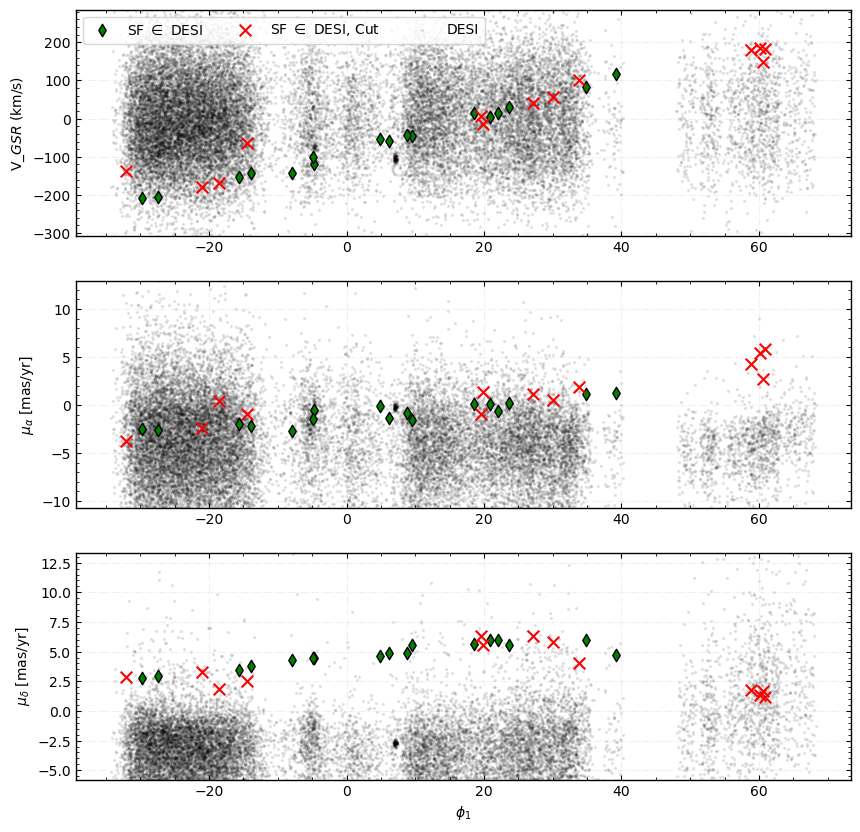

In [18]:
importlib.reload(st)
plt_trim.plot_params['background']['alpha']=0.08
plt_trim.kin_plot(showStream=True, background=True, show_sf_only=False)

In [51]:
#-----------------------#
vgsr_max=300 #[km/s]
vgsr_min=-300
#-----------------------#

selection_fine.add_mask(name='VGSR',
        mask_func=lambda df: (df['VGSR'] < vgsr_max) & (df['VGSR'] > vgsr_min))

Mask added: 'VGSR'


In [57]:
#-----------------------#
pmra_wiggle = 5 # [mas/yr]
#-----------------------#

# selection_fine.add_mask(name='PMRA',
#         mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))
# selection_fine.add_mask(name='PMRA',
#         mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))

selection_fine.add_mask(
    name='PMRA',
    mask_func=lambda df: (
        (
            df['PMRA'] >= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmRA'] - pmra_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmRA'] - pmra_wiggle])
        ) &
        (
            df['PMRA'] <= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmRA'] + pmra_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmRA'] + pmra_wiggle])
        ) ))

Mask added: 'PMRA'


In [58]:
# selection_fine.add_mask(name='PMDEC',
#         mask_func=lambda df: (df['PMDEC'] < pmdec_max) & (df['PMDEC'] > pmdec_min))

#-----------------------#
pmdec_wiggle = 5 # [mas/yr]
#-----------------------#


selection_fine.add_mask(
    name='PMDEC',
    mask_func=lambda df: (
        (
            df['PMDEC'] >= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmDE'] - pmdec_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmDE'] - pmdec_wiggle])
        ) &
        (
            df['PMDEC'] <= np.interp(df['phi1'], [SoI.data.SoI_streamfinder['phi1'].min(), SoI.data.SoI_streamfinder['phi1'].max()],
                                            [SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmin(), 'pmDE'] + pmdec_wiggle,
                                             SoI.data.SoI_streamfinder.loc[SoI.data.SoI_streamfinder['phi1'].idxmax(), 'pmDE'] + pmdec_wiggle])
        ) ))

Mask added: 'PMDEC'


## Lets look at our cuts!

In [59]:
selection_fine.list_masks()

Active masks:
- 3D
- phi2
- feh
- iso
- VGSR
- PMRA
- PMDEC
- iso_wide
- VGSR_wide
- PMRA_wide
- PMDEC_wide


...'3D' selected 1887283 stars
...'phi2' selected 275775 stars
...'feh' selected 770814 stars
...'iso' selected 1130397 stars
...'VGSR' selected 4070494 stars
...'PMRA' selected 2105704 stars
...'PMDEC' selected 1994292 stars
Selection for specified masks: 4044 / 4075716 stars.
...'iso' selected 1130397 stars
...'VGSR' selected 4070494 stars
...'PMRA' selected 2105704 stars
...'PMDEC' selected 1994292 stars
Selection for specified masks: 4044 / 4075716 stars.
Created cut_confirmed_sf_and_desi with 16 stars that were filtered out
Number of stars in SF: 297, Number of DESI and SF stars: 14
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 283
Created cut_confirmed_sf_and_desi with 16 stars that were filtered out
Number of stars in SF: 297, Number of DESI and SF stars: 14
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 283


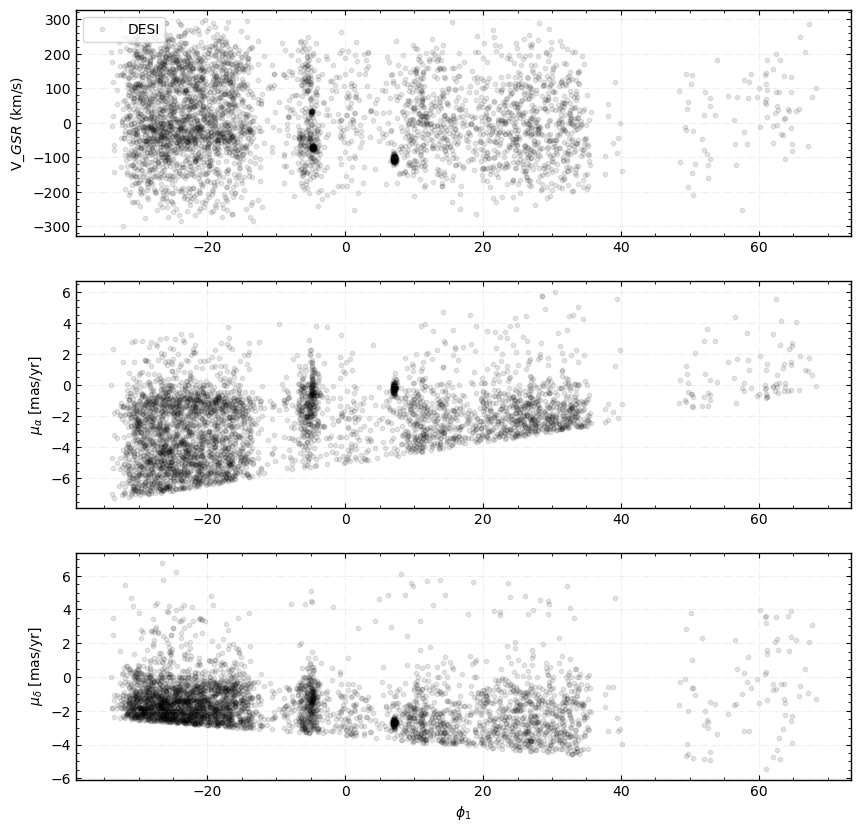

In [60]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data
mask = selection_fine.get_masks(['3D', 'phi2', 'feh','iso', 'VGSR', 'PMRA', 'PMDEC'])

# Using the new method that replaces the 4-line pattern
# VGSR is now automatically computed for confirmed_sf_not_desi within mask_stream()
trimmed_stream = SoI.mask_stream(mask)

plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.plot_params['sf_in_desi']['alpha']= 0.9
plt_trim.plot_params['background']['alpha']= 0.1
plt_trim.plot_params['background']['s'] = 10
#-----------------------#
plt_trim.kin_plot(showStream=False, show_sf_only=False, background=True) # You can change showStream to True to see where the STREAMFINDER stars are in this space.
                                                                       # If there aren't many SF stars in DESI, you can show the stars not in DESI as a guide by setting show_sf_only to True
#-----------------------#

Lets look at an example of a stream (Sylgr-I21) being spotted once our initial cuts have been made. We can see lines of overdensities in all three kinematic dimensions!

 Furthermore, we can overlay the STREAMFINDER stars to see that this overdensity lies on the previously disovered stream, and which SF stars we have cutout.

<img src="/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/img_examples/ex_stream.png" alt="Stream Image" width="600"/> <img src="/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/img_examples/ex-sf.png" alt="Stream Image" width="600"/>

These cuts are quite restrictive, we'll widen them now to have more stars to run our mixture model on.

In [40]:
import copy
selection_mcmc = copy.copy(selection_fine)

In [ ]:
#-----------------------#
colour_wiggle = 0.2 # [dex]

pmdec_max = 10 # [mas/yr]
pmdec_min = -2.5

vgsr_max=  300 # [km/s]
vgsr_min= -300

pmra_max = 10 # [mas/yr]
pmra_min = -5
#-----------------------#

selection_mcmc.add_mask(name='iso_wide',
        mask_func=lambda df: (stream_funcs.betw(SoI.data.desi_colour_idx, SoI.isochrone_fit(SoI.data.desi_abs_mag), colour_wiggle)))

selection_mcmc.add_mask(name='VGSR_wide',
        mask_func=lambda df: (df['VGSR'] < vgsr_max) & (df['VGSR'] > vgsr_min))

selection_mcmc.add_mask(name='PMRA_wide',
        mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))

selection_mcmc.add_mask(name='PMDEC_wide',
        mask_func=lambda df: (df['PMDEC'] < pmdec_max) & (df['PMDEC'] > pmdec_min))

Mask added: 'iso_wide'
Mask added: 'VGSR_wide'
Mask added: 'PMRA_wide'
Mask added: 'PMDEC_wide'


In [42]:
mcmc_mask = selection_mcmc.get_masks(['3D', 'phi2', 'feh','iso_wide', 'VGSR_wide', 'PMRA_wide', 'PMDEC_wide'])



...'3D' selected 1887283 stars
...'phi2' selected 275775 stars
...'feh' selected 770814 stars


...'iso_wide' selected 1130397 stars
...'VGSR_wide' selected 46599 stars
...'PMRA_wide' selected 3608525 stars
...'PMDEC_wide' selected 3805775 stars
Selection for specified masks: 851 / 4075716 stars.


Created cut_confirmed_sf_and_desi with 28 stars that were filtered out
Number of stars in SF: 297, Number of DESI and SF stars: 2
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 295


(<Figure size 1000x1500 with 5 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>, <Axes: ylabel='V$_{GSR}$ (km/s)'>,
        <Axes: ylabel='$\\mu_{\\alpha}$ [mas/yr]'>,
        <Axes: ylabel='$\\mu_{\\delta}$ [mas/yr]'>,
        <Axes: xlabel='$\\phi_1$', ylabel='[Fe/H]'>], dtype=object))

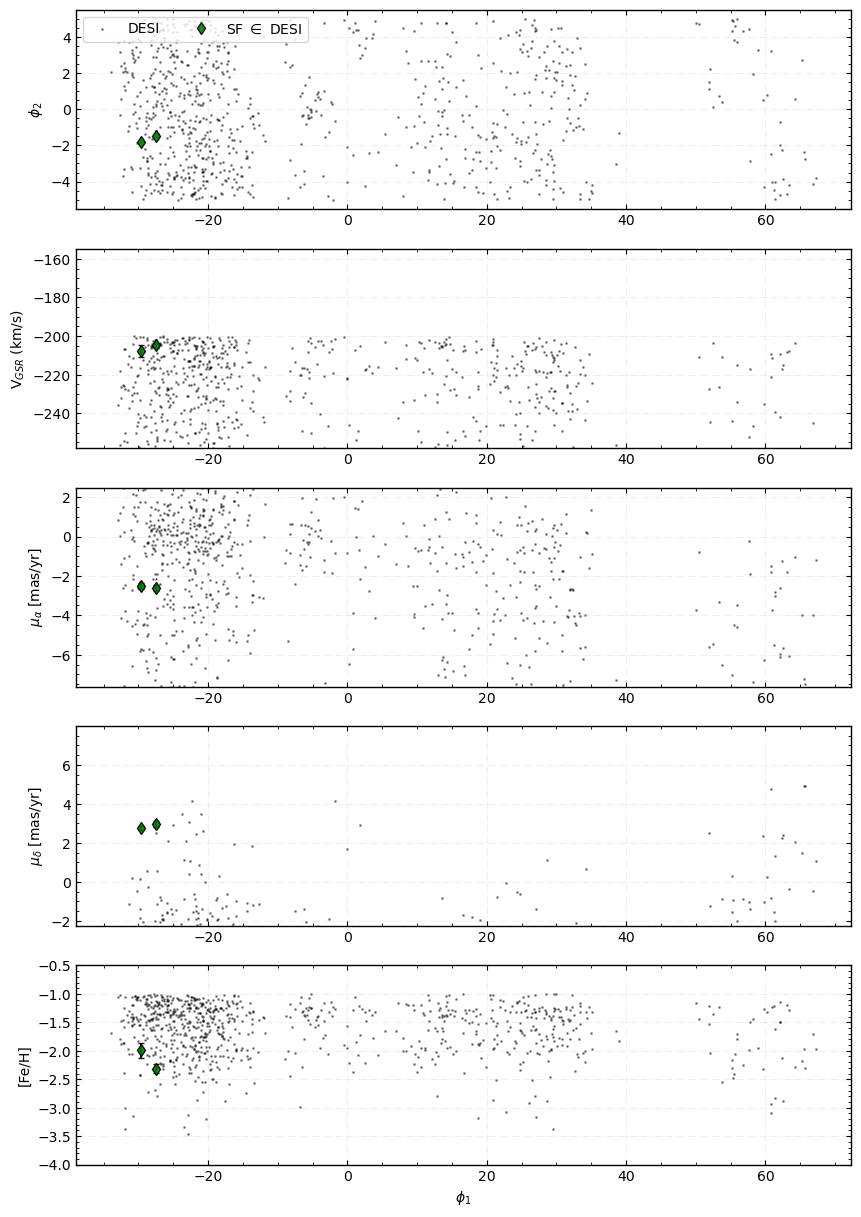

In [43]:
importlib.reload(st)
tomcmc_stream = SoI.mask_stream(mcmc_mask)

plt_trim = st.StreamPlotter(tomcmc_stream)
plt_trim.plot_params['sf_in_desi']['alpha']= 0.9
plt_trim.plot_params['background']['alpha']= 0.4
plt_trim.plot_params['background']['s'] = 1
#-----------------------#
plt_trim.sixD_plot(showStream=True, show_sf_only=False, background=True) # You can change showStream to True to see where the STREAMFINDER stars are in this space.
                                                                       # If there aren't many SF stars in DESI, you can show the stars not in DESI as a guide by setting show_sf_only to True
#-----------------------#

# Optimizing

If you see a stream above, you may continue with the rest of the notebook!

Before jumping into running MCMC, we will find a good starting point using `scipy.minimize`.

Streams aren't flat lines in $\phi_1$ dynamically, so we want to allow our fits to vary along the track.

```python
#-----------------------#
no_of_spline_points = 5
#-----------------------#
```
Typically we want between 3 and 5 spline points.


In [44]:
importlib.reload(st)
#-----------------------#
no_of_spline_points = 5
#-----------------------#

# Define truncation parameters based on our selection cuts
truncation_params = {
    'vgsr_min': vgsr_min, 'vgsr_max': vgsr_max,
    'feh_min': -4.0, 'feh_max': feh_cut,
    'pmra_min': pmra_min, 'pmra_max': pmra_max,
    'pmdec_min': pmdec_min, 'pmdec_max': pmdec_max
}

MCMeta = st.MCMeta(no_of_spline_points, tomcmc_stream, trimmed_stream.data.confirmed_sf_and_desi, truncation_params=truncation_params)

Making stream initial guess based on galstream and STREAMFINDER...
Stream VGSR dispersion from trimmed SF: 92.71 km/s
Stream mean metallicity from trimmed SF: -2.19 +- 0.165 dex
Stream PMRA dispersion from trimmed SF: 1.22 mas/yr
Stream PMDEC dispersion from trimmed SF: 0.98 mas/yr
Making background initial guess...
Background velocity: -240.25 +- 36.24 km/s
Background metallicity: -1.62 +- 0.462 dex
Background PMRA: -2.78 +- 5.01 mas/yr
Background PMDEC: -6.53 +- 5.12 mas/yr


We're doing a mixture model, but what are we mixing? Lets take a look at our intial guesses below:

Initial Parameters:
lsigvgsr: 1.9671
vgsr_spline_points: [-258.79135535 -151.03091483  -20.08228495  134.05453427  311.37954283]
feh1: -2.1887
lsigfeh: -0.7830
lsigpmra: 0.0854
pmra_spline_points: [-3.00587425 -2.02261548 -0.49514594  1.57653438  4.19242548]
lsigpmdec: -0.0068
pmdec_spline_points: [1.01794505 3.87864475 5.34565023 5.41896148 4.09857852]
bv: -240.2523
lsigbv: 1.5592
bfeh: -1.6241
lsigbfeh: -0.3357
bpmra: -2.7806
lsigbpmra: 0.6999
bpmdec: -6.5336
lsigbpmdec: 0.7091


(<Figure size 900x900 with 4 Axes>,
 array([[<Axes: xlabel='V$_{GSR}$ (km/s)'>, <Axes: xlabel='[Fe/H]'>],
        [<Axes: xlabel='$\\mu_{RA}$ (mas/yr)'>,
         <Axes: xlabel='$\\mu_{DEC}$ (mas/yr)'>]], dtype=object))

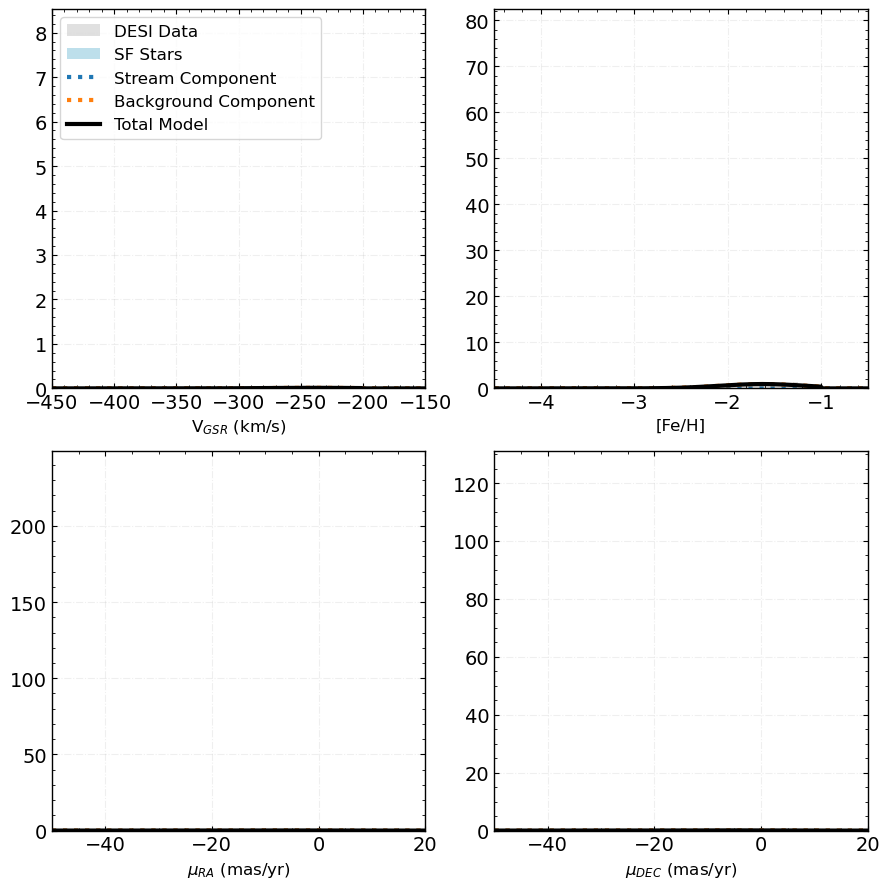

In [45]:
plt_mcmeta = st.StreamPlotter(MCMeta)

# Show our initial parameter guesses
print("Initial Parameters:")
for param, value in MCMeta.initial_params.items():
    if isinstance(value, np.ndarray):
        print(f"{param}: {value}")
    else:
        print(f"{param}: {value:.4f}")

# Plot the Gaussian mixture model based on our initial guesses
plt_mcmeta.gaussian_mixture_plot(showStream=True, background=True)

## Prior

In [46]:
vgsr_range_wiggle = 50
pmra_range_wiggle = 10
pmdec_range_wiggle = 10
lsigvgsr_r = (-4, 4)

vgsr_ranges = [(v - vgsr_range_wiggle, v + vgsr_range_wiggle) for v in MCMeta.initial_params['vgsr_spline_points']]
pmra_ranges = [(v - pmra_range_wiggle, v + pmra_range_wiggle) for v in MCMeta.initial_params['pmra_spline_points']]
pmdec_ranges = [(v - pmdec_range_wiggle, v + pmdec_range_wiggle) for v in MCMeta.initial_params['pmdec_spline_points']]

feh1_r = (-4,-1.5)
lsigfeh_r = (-2,4)
lsigpmra_r = (-5, 1)
lsigpmdec_r = (-5, 1)
bv_r = (-400, 400)
lsigbv_r = (-2,4)
bfeh_r = (-4, 4)
lsigbfeh_r = (-2,2)
bpmra_r = (-20, 20)
lsigbpmra_r = (-2,3)
bpmdec_r = (-20, 10)
lsigbpmdec_r = (-2,3)

pstream_r = (0.0, 1.0)

prior = [
    pstream_r,              # pstream (single value)
    *vgsr_ranges,           # vgsr_spline_points (5 values)
    lsigvgsr_r,             # lsigvgsr (single value)
    feh1_r, lsigfeh_r,      # feh parameters
    *pmra_ranges,           # pmra_spline_points (5 values)  
    lsigpmra_r,             # lsigpmra (single value)
    *pmdec_ranges,          # pmdec_spline_points (5 values)
    lsigpmdec_r,            # lsigpmdec (single value)
    bv_r, lsigbv_r, bfeh_r, lsigbfeh_r,  # background parameters
    bpmra_r, lsigbpmra_r, bpmdec_r, lsigbpmdec_r
]

In [47]:
importlib.reload(stream_funcs)

phi1_spline_points = MCMeta.phi1_spline_points  # x-coordinates for splines

spline_k = MCMeta.spline_k

# Create initial parameter array - pstream and lsigvgsr are now single constant values
p0_guess = [
    0.1,                                                 # pstream (constant stream fraction)
    MCMeta.initial_params['vgsr_spline_points'],         # VGSR spline points
    MCMeta.initial_params['lsigvgsr'],                   # lsigvgsr (constant log velocity dispersion)
    MCMeta.initial_params['feh1'],                       # mean [Fe/H]
    MCMeta.initial_params['lsigfeh'],                    # log(sigma_[Fe/H])
    MCMeta.initial_params['pmra_spline_points'],         # PMRA spline points
    MCMeta.initial_params['lsigpmra'],                   # log(sigma_pmra)
    MCMeta.initial_params['pmdec_spline_points'],        # PMDEC spline points
    MCMeta.initial_params['lsigpmdec'],                  # log(sigma_pmdec)
    MCMeta.initial_params['bv'],                         # background VGSR
    MCMeta.initial_params['lsigbv'],                     # log(sigma_background_vgsr)
    MCMeta.initial_params['bfeh'],                       # background [Fe/H]
    MCMeta.initial_params['lsigbfeh'],                   # log(sigma_background_feh)
    MCMeta.initial_params['bpmra'],                      # background PMRA
    MCMeta.initial_params['lsigbpmra'],                  # log(sigma_background_pmra)
    MCMeta.initial_params['bpmdec'],                     # background PMDEC
    MCMeta.initial_params['lsigbpmdec']                  # log(sigma_background_pmdec)
]

# Updated parameter labels - pstream and lsigvgsr are now single parameters
param_labels = ['pstream', 'vgsr_spline_points', 'lsigvgsr', 'feh1', 'lsigfeh', 
                'pmra_spline_points', 'lsigpmra', 'pmdec_spline_points', 'lsigpmdec',
                'bv', 'lsigbv', 'bfeh', 'lsigbfeh', 'bpmra', 'lsigbpmra', 'bpmdec', 'lsigbpmdec']

vgsr_trunc = [MCMeta.truncation_params['vgsr_min'], MCMeta.truncation_params['vgsr_max']]
feh_trunc = [MCMeta.truncation_params['feh_min'], MCMeta.truncation_params['feh_max']]  
pmra_trunc = [MCMeta.truncation_params['pmra_min'], MCMeta.truncation_params['pmra_max']]
pmdec_trunc = [MCMeta.truncation_params['pmdec_min'], MCMeta.truncation_params['pmdec_max']]

array_lengths = [len(x) if isinstance(x, np.ndarray) else 1 for x in p0_guess]
flat_p0_guess = np.hstack(p0_guess)


# Fixed optimization function with correct signature
optfunc = lambda theta: -stream_funcs.spline_lnprob_1D(
    theta, prior, phi1_spline_points,  # Only phi1_spline_points needed
    tomcmc_stream.data.desi_data['VGSR'], tomcmc_stream.data.desi_data['VRAD_ERR'],
    tomcmc_stream.data.desi_data['FEH'], tomcmc_stream.data.desi_data['FEH_ERR'],
    tomcmc_stream.data.desi_data['PMRA'], tomcmc_stream.data.desi_data['PMRA_ERROR'],
    tomcmc_stream.data.desi_data['PMDEC'], tomcmc_stream.data.desi_data['PMDEC_ERROR'],
    tomcmc_stream.data.desi_data['phi1'], 
    trunc_fit=True, feh_fit=True, assert_prior=False, k=spline_k, 
    reshape_arr_shape=array_lengths,
    vgsr_trunc=vgsr_trunc, feh_trunc=feh_trunc, 
    pmra_trunc=pmra_trunc, pmdec_trunc=pmdec_trunc
)

# Run optimization
print("Running optimization...")
%time result = optimize.minimize(optfunc, flat_p0_guess, method="Nelder-Mead")
print(result.message)

# Reshape and process results
reshaped_result = stream_funcs.reshape_arr(result.x, array_lengths)
output = stream_funcs.get_paramdict(reshaped_result, labels=param_labels)

print("\nOptimized Parameters:")
for label, value in output.items():
    if label.startswith('l'):
        print(f"{label[1:]}: {10**value:.4f}")
    else:
        print(f"{label}: {value:.4f}" if isinstance(value, (int, float)) else f"{label}: {value}")

Running optimization...
CPU times: user 22.4 s, sys: 4.9 ms, total: 22.4 s
Wall time: 22.4 s
Maximum number of function evaluations has been exceeded.

Optimized Parameters:
pstream: 0.0000
vgsr_spline_points: [-209.16545341 -148.33871961  -34.96766396  135.7025028   361.30200531]
sigvgsr: 421.0347
feh1: -3.7403
sigfeh: 1.6509
pmra_spline_points: [-2.50377528 -2.77573335 -0.33121096  2.23887774  7.64540821]
sigpmra: 1.3942
pmdec_spline_points: [1.22412625 4.51819744 5.6877384  6.237983   5.59499528]
sigpmdec: 0.9823
bv: -19.1744
sigbv: 101.9068
bfeh: -1.1757
sigbfeh: 0.6665
bpmra: -0.1514
sigbpmra: 6.7112
bpmdec: -6.3034
sigbpmdec: 5.3737
CPU times: user 22.4 s, sys: 4.9 ms, total: 22.4 s
Wall time: 22.4 s
Maximum number of function evaluations has been exceeded.

Optimized Parameters:
pstream: 0.0000
vgsr_spline_points: [-209.16545341 -148.33871961  -34.96766396  135.7025028   361.30200531]
sigvgsr: 421.0347
feh1: -3.7403
sigfeh: 1.6509
pmra_spline_points: [-2.50377528 -2.77573335 -0.


Plotting optimized Gaussian mixture...


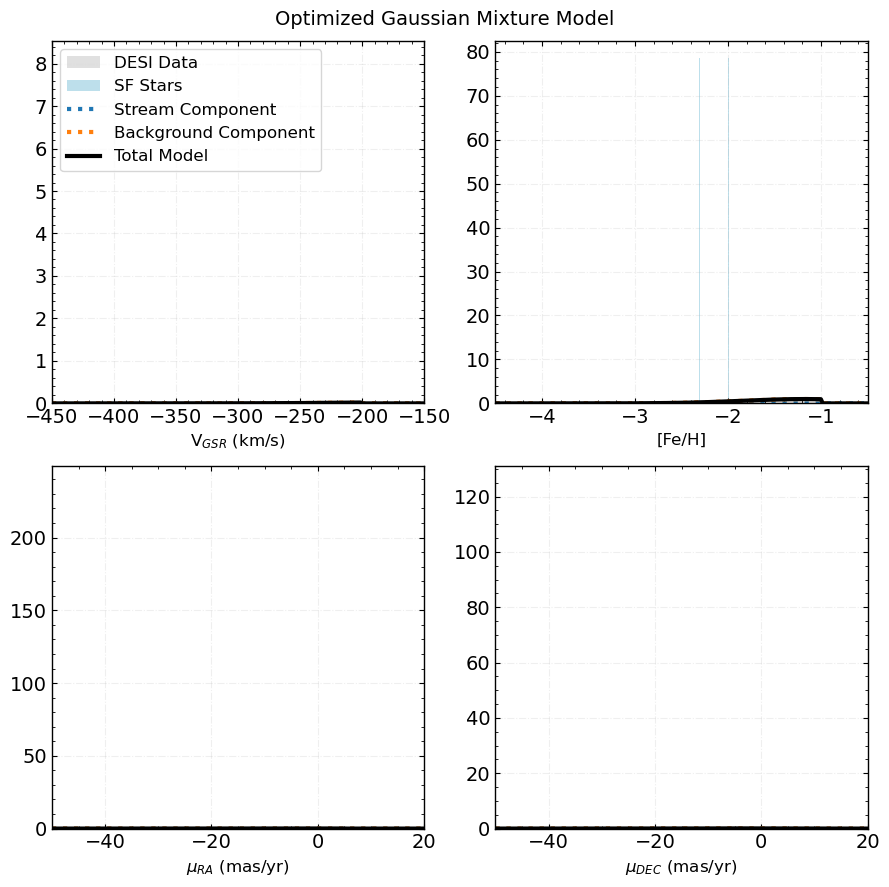

Your prior is good, you've found something!
All 70 walkers initialized successfully!


In [48]:
# Add optimization results to MCMeta class
MCMeta.optimized_params = output
MCMeta.optimization_result = result

# Create a new plotter object with the optimized parameters
plt_optimized = st.StreamPlotter(MCMeta)


original_params = MCMeta.initial_params.copy()
optimized_for_plotting = output.copy()


if 'lsigvgsr' in optimized_for_plotting:
    optimized_for_plotting['lsigvgsr'] = optimized_for_plotting['lsigvgsr']

MCMeta.initial_params = optimized_for_plotting

print("\nPlotting optimized Gaussian mixture...")
plt_optimized.gaussian_mixture_plot(showStream=True, background=True)

# Restore original initial_params
MCMeta.initial_params = original_params

plt.suptitle('Optimized Gaussian Mixture Model', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Below checks if we picked good priors


nparams = len(param_labels)
nwalkers = 70

p0 = flat_p0_guess 
ep0 = np.zeros(len(p0)) + 0.01

# Generate walker positions around the starting point
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)

# Clip pstream to valid range [0, 1] - first parameter only
p0s[:,0] = np.clip(p0s[:,0], 1e-10, 1 - 1e-10)

# Test likelihood for all walkers using the modified function
lkhds = [stream_funcs.spline_lnprob_1D(
    p0s[j], prior, phi1_spline_points, 
    tomcmc_stream.data.desi_data['VGSR'], tomcmc_stream.data.desi_data['VRAD_ERR'],
    tomcmc_stream.data.desi_data['FEH'], tomcmc_stream.data.desi_data['FEH_ERR'],
    tomcmc_stream.data.desi_data['PMRA'], tomcmc_stream.data.desi_data['PMRA_ERROR'],
    tomcmc_stream.data.desi_data['PMDEC'], tomcmc_stream.data.desi_data['PMDEC_ERROR'],
    tomcmc_stream.data.desi_data['phi1'], 
    trunc_fit=True, feh_fit=True, assert_prior=True, k=spline_k, 
    reshape_arr_shape=array_lengths,
    vgsr_trunc=vgsr_trunc, feh_trunc=feh_trunc, 
    pmra_trunc=pmra_trunc, pmdec_trunc=pmdec_trunc
) for j in range(nwalkers)]

# Check if prior is good - this is the key test from your original code
if sum(np.array(lkhds) > -9e9) == nwalkers:
    print('Your prior is good, you\'ve found something!')
elif sum(np.array(lkhds) > -9e9) != nwalkers:
    print('Your prior is too restrictive, try changing the values listed above!')

# Assert that all walkers have good likelihoods
assert np.all(np.array(lkhds) > -9e9), f"Only {sum(np.array(lkhds) > -9e9)}/{nwalkers} walkers have valid likelihoods"

print(f"All {nwalkers} walkers initialized successfully!")

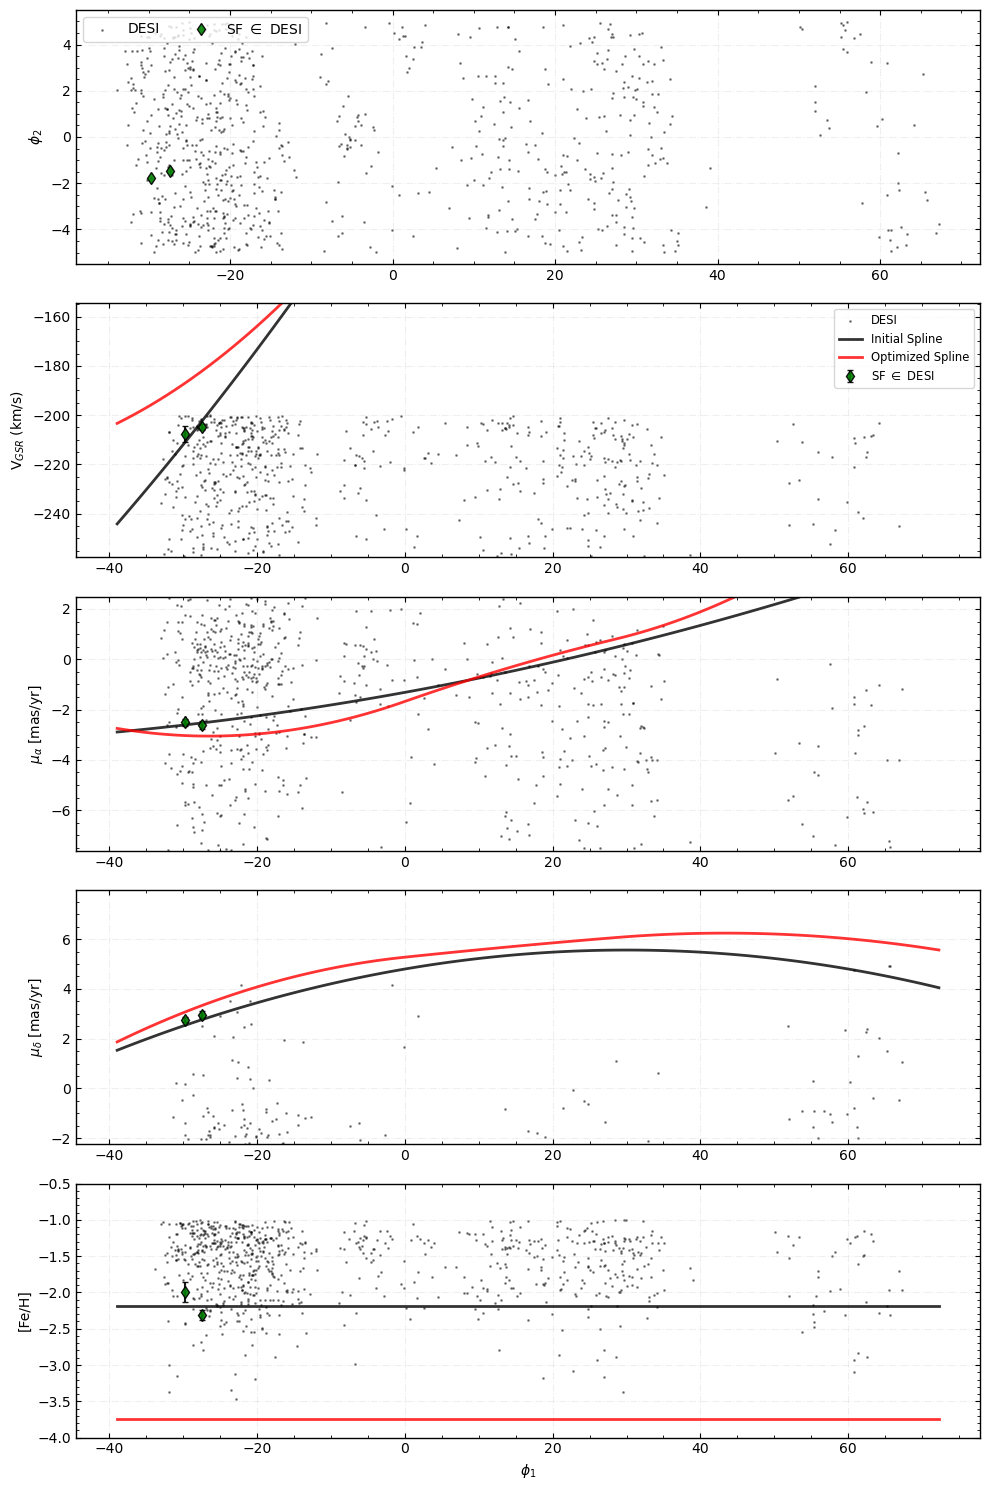

In [49]:
importlib.reload(st)

plt_enhanced = st.StreamPlotter(MCMeta) 
plt_enhanced.plot_params['sf_in_desi']['alpha'] = 0.9
plt_enhanced.plot_params['background']['alpha'] = 0.4
plt_enhanced.plot_params['background']['s'] = 1

fig, ax = plt_enhanced.sixD_plot(
    showStream=True, 
    show_sf_only=False, 
    background=True,
    show_initial_splines=True,
    show_optimized_splines=True,
    show_sf_errors=True  # Now enable error bars
)

plt.tight_layout()
plt.show()